#  [모듈 4.2] 훈련된 모델로 부터 추론 (병령로 예측)

- 4.1 노트북과 유사하지만, 추론을 병렬로 하는 부분이 다릅니다.
-------


# 0. 환경 셋업

In [8]:
%store -r 

In [9]:
# -- initialize the AFD client 
import boto3
client = boto3.client('frauddetector')

import uuid
import numpy as np

# 1. 테스트 데이터 세트 준비

## 추론 샘플 사이즈

In [10]:
sample_size = 19999

## 테스트 데이터 로딩 및 샘플링

EVENT_TIMESTAMP를 FD 에서 요구하는 ISO-8601 Datetime format으로 변경 합니다.

In [11]:
import pandas as pd

date_cols = ['EVENT_TIMESTAMP']
test_df = pd.read_csv(s3_test_data_uri, parse_dates = date_cols)
print("test_df : ", test_df.shape)
test_df = test_df.sample(n=sample_size, random_state=100)
print("Sample Size : ", test_df.shape)
test_df.head(2)

test_df :  (20000, 7)
Sample Size :  (19999, 7)


,EVENT_LABEL,str_ip,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP
2917,0,str_93021,str_3,str_1,str_8,str_280,2017-11-09 00:08:26
2234,0,str_16464,str_15,str_1,str_15,str_386,2017-11-09 08:58:44


## 추론 입력 포맷(Payload) 로 변경

In [12]:
timestampStr_list = test_df['EVENT_TIMESTAMP'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))
record_count = test_df.shape[0]
print("record_count: ", record_count)
pred_data = test_df[eventVariables].head(record_count).astype(str).to_dict(orient='records')
pred_data[0:2]



record_count:  19999


[{'str_ip': 'str_93021',
  'str_app': 'str_3',
  'str_device': 'str_1',
  'str_os': 'str_8',
  'str_channel': 'str_280'},
 {'str_ip': 'str_16464',
  'str_app': 'str_15',
  'str_device': 'str_1',
  'str_os': 'str_15',
  'str_channel': 'str_386'}]

# 2. 추론
- 아래는 정상적으로 실행이 될 경우에 약 2분이 소요 됩니다.
- 만약 에러가 발생하면 "병렬 처리" 에 대한 에러 입니다. 이럴 경우에 다시 한번 노트북을 실행 해 주세요.

In [13]:
%%time

import dask

@dask.delayed
def _predict(rec):
    eventId = uuid.uuid1()
    try:
        pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                           detectorVersionId='1',
                                           eventId = str(eventId),
                                           eventTypeName = EVENT_TYPE,
                                           eventTimestamp = timestampStr, 
                                           entities = [{'entityType': ENTITY_TYPE, 
                                                        'entityId':str(eventId.int)}],
                                           eventVariables=rec) 
    except:
        print("Error")

    return pred


######

predicted_dat = []

for rec , timestampStr in zip(pred_data, timestampStr_list):
    # print(timestampStr)
    eventId = uuid.uuid1()
    pred = dask.delayed(_predict)(rec)

    
    rec["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
    rec["outcome"] = pred['ruleResults'][0]['outcomes'][0]
    predicted_dat.append(rec)

predict_recs = dask.compute(*predicted_dat)    

CPU times: user 1min 29s, sys: 7.91 s, total: 1min 37s
Wall time: 1min 43s


In [18]:
# -- review your predictons -- 
predictions = pd.DataFrame(predict_recs)
# predictions.head(10)
predictions

,str_ip,str_app,str_device,str_os,str_channel,score,outcome
0,str_93021,str_3,str_1,str_8,str_280,63.0,approve
1,str_16464,str_15,str_1,str_15,str_386,63.0,approve
2,str_99519,str_2,str_1,str_22,str_435,63.0,approve
3,str_15643,str_9,str_1,str_19,str_466,63.0,approve
4,str_62916,str_3,str_1,str_19,str_280,63.0,approve
...,...,...,...,...,...,...,...
19994,str_305603,str_12,str_1,str_41,str_497,63.0,approve
19995,str_8505,str_13,str_1,str_13,str_477,63.0,approve
19996,str_212695,str_9,str_1,str_19,str_445,63.0,approve
19997,str_327491,str_6,str_1,str_22,str_125,63.0,approve


# 3. 추론 예측 결과 값 분석


## 추론 예측 스코어 분포 확인

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


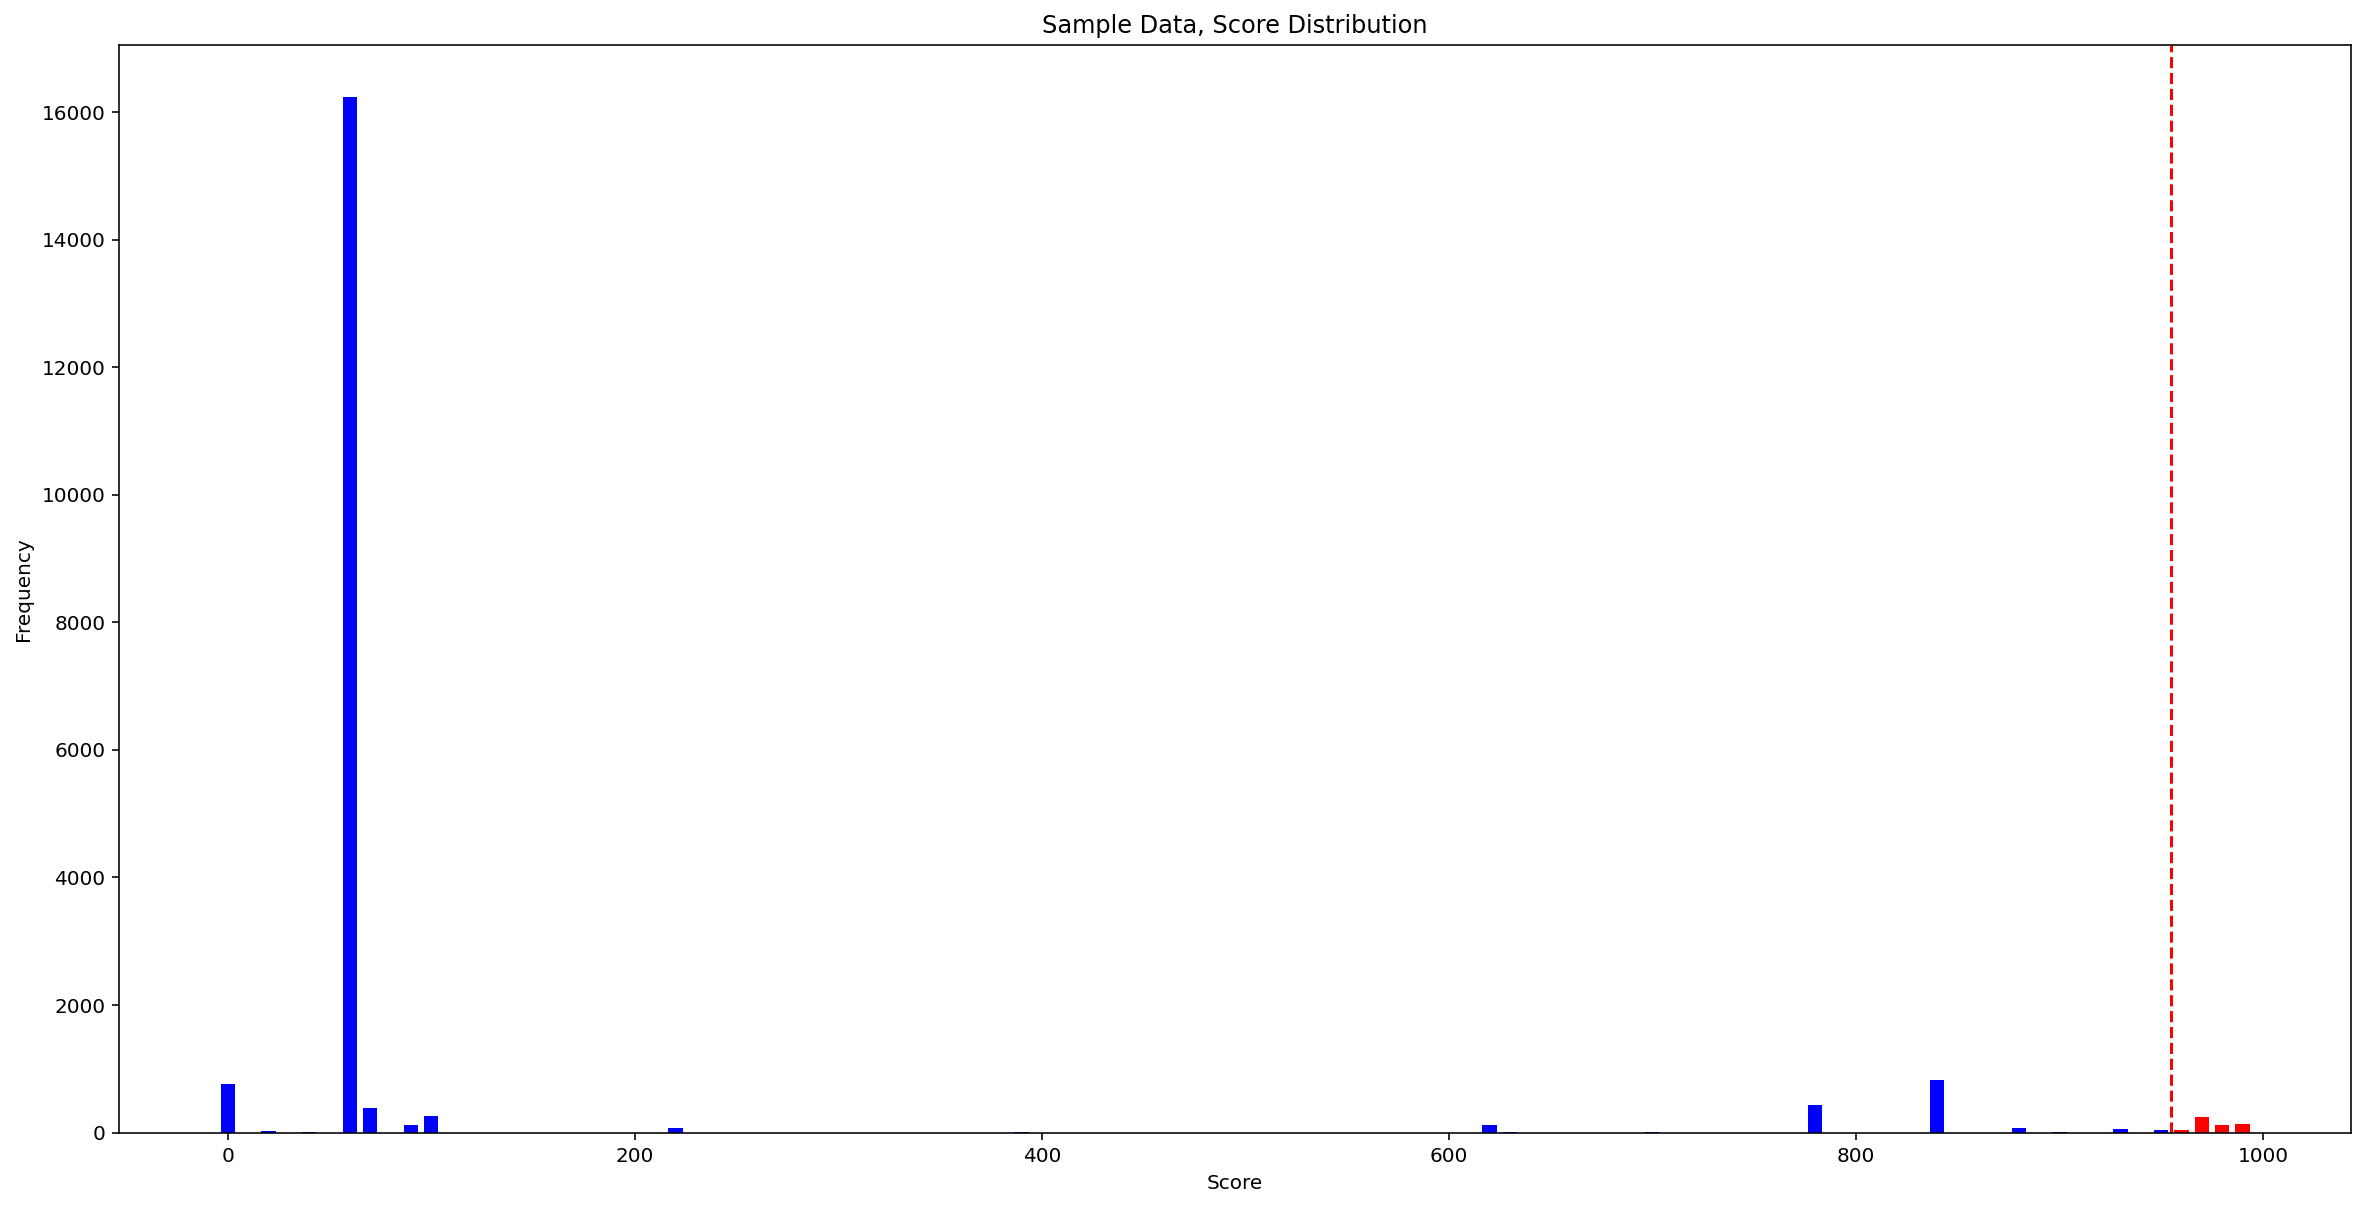

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions['score_bin'] = pd.cut(predictions['score'],100 ,labels= list(range(0,1000,10)))
predictions.loc[predictions['score'] >= score_fraud_threshold, 'score_outcome'] = 'predicted_fraud'
predictions.loc[predictions['score'] < score_fraud_threshold, 'score_outcome'] = 'predicted_legit'
ctab = pd.crosstab(predictions['score_bin'], predictions['score_outcome']).reset_index()
# print(predictions.head(100))
plt.figure(figsize=(20,10))
plt.bar(ctab['score_bin'], ctab['predicted_fraud'], width=7, color='red')
plt.bar(ctab['score_bin'], ctab['predicted_legit'], width=7, color='blue')
plt.axvline(x=score_fraud_threshold, ls='--', C='red')
plt.title("Sample Data, Score Distribution")
#plt.text( 955, 700, 'score >= 985')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

## 평가 지표 생성
- F1, Precsion, Recall, Accuracy를 확인 
- Confusion Matrixa 확인

## Fraud 스코어 기준
- 아래 점수 기준으로 Fruad 로 정의 하였습니다.

In [22]:
print("score_fraud_threshold: ", score_fraud_threshold)

score_fraud_threshold:  955.0


In [20]:
#predictions['pred_label'] = np.where(predictions['outcome'] == '[approve]',0,1)
predictions['pred_label'] = np.where(predictions['outcome'] == 'fraud',1,0)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19459
           1       0.89      0.09      0.16       540

    accuracy                           0.98     19999
   macro avg       0.93      0.55      0.58     19999
weighted avg       0.97      0.98      0.97     19999

[[19453   491]
 [    6    49]]


<Figure size 432x288 with 0 Axes>

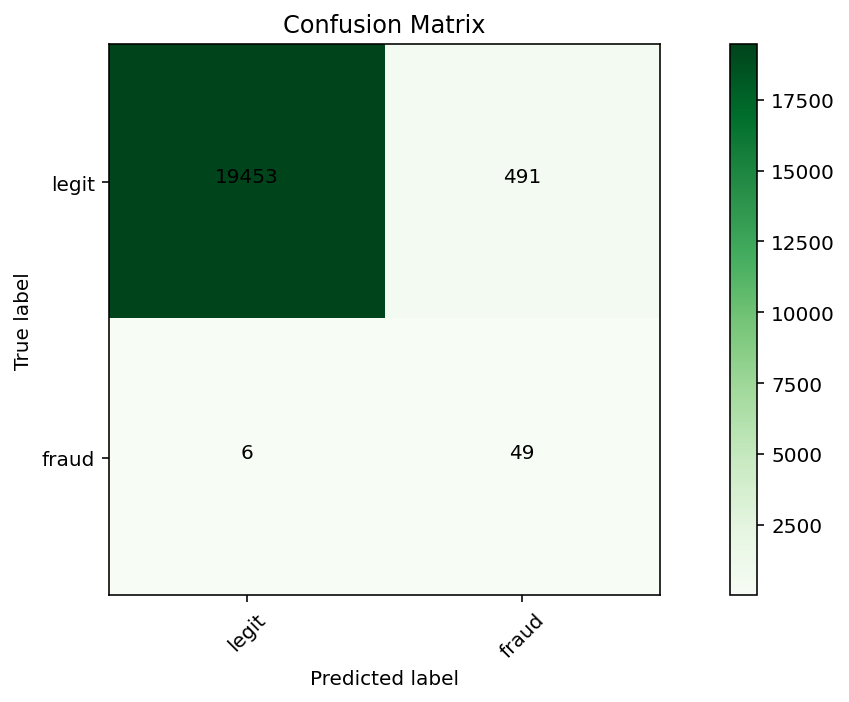

In [21]:
from sklearn.metrics import classification_report, roc_auc_score
from IPython.display import display as dp
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from src.p_utils import plot_conf_mat     

%matplotlib inline
%config InlineBackend.figure_format='retina'


def compute_f1(pred, test_df, true_label_col, pred_label_col):
    test = test_df.copy()
    test= test.reset_index(drop=True)
    print(classification_report(pred[pred_label_col], test[true_label_col]))
    
    cm = confusion_matrix(y_true= test[true_label_col], y_pred= pred[pred_label_col])
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    plot_conf_mat(cm, 
                  classes=['legit', 'fraud'], 
                  title='Confusion Matrix')
    plt.show()    



compute_f1(predictions, test_df, 
           true_label_col='EVENT_LABEL',
           pred_label_col='pred_label'           
          )